In [243]:
import nltk
import scipy.stats as stats
import pandas as pd
import numpy as np
import statsmodels.api as sm
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

def get_parts_of_speech(prod_desc):
    
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(prod_desc)
    text = nltk.Text(tokens)
    tagged = nltk.pos_tag(text, tagset='universal')

    counts = Counter(tag for word,tag in tagged)
    for word, tag in tagged:
        counts[tag] += 1
    total = sum(counts.values())
    counts_norm = dict((word, float(count)/total) for word,count in counts.items())
    
    return counts_norm

def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    #rgr = sm.OLS(y,x).fit()
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)
    res = y - pred

    plt.subplot(1, 3, 1)
    plt.hist(res)
    #plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Residuals Distribution")
    plt.xlabel("Residuals")
    #plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

#load data
data = pd.read_csv('..//data//ALL_COUNTRIES_data.csv')

#clean price field
#data['list_price'] = data['list_price'].str.replace('$','').astype(float)

data = data[data['list_price'] < 500]
data = data[data['list_price'] > 10]
data = data[data['piece_count'] > 10]

In [244]:
#number of themes present in
data['num_themes'] = data['prod_id'].groupby(data['prod_id']).transform('count')
data['num_themes'] = np.where(data['num_themes'] > 1, 1, 0)

# review fields
data['num_reviews'] = data['num_reviews'].fillna(0)
review_map = {
    
    'Very Easy':1,
    'Easy':2,
    'Average':3,
    'Challenging':4
    
}
data['review_diff_int'] = data['review_difficulty'].map(review_map)

# description text fields
data['cont_tm'] = np.where(data['set_name'].str.contains('™'),1 , 0)
data['cont_lego'] = np.where(data['prod_desc'].str.contains('LEGO®'), 1, 0)
data['desc_word_count'] = data['prod_long_desc'].apply(lambda x: len(x))
data['desc_bullet_count'] = data['prod_long_desc'].apply(lambda x: len(x.split('\n')))
data['cont_battery'] = np.where(data['prod_long_desc'].str.contains(r'battery|batteries'), 1, 0)

#handle ages
max_age = 23
data['ages'] = data['ages'].fillna(data['ages'].value_counts().index[0])
data['ages'] = data['ages'].str.replace('½','')
data[['age_bot','age_top']] = data['ages'].str.split(r'-|\+', expand = True)
data['age_top'] = data['age_top'].replace('',max_age)
data['age_top'] = data['age_top'].fillna(max_age).astype(int)
data['age_top'] = np.where(data['age_top'] > max_age, max_age, data['age_top'])
data['age_bot'] = data['age_bot'].fillna(2).astype(int)
data['age_mean'] = (data['age_top'] + data['age_bot']) / 2

#piece count field
data['piece_count'] = data['piece_count'].fillna(data['piece_count'].mean())
data = data[data['piece_count'] > 1]

#use this when we have more info
#datae['piece_count'] = datae.groupby("ages").transform(lambda x: x.fillna(x.mean()))['piece_count']

#turn countries into binary fields
data = pd.concat((data, pd.get_dummies(data['country'])), axis = 1)

#get part of speech
data['pos_tags'] = data['prod_long_desc'].apply(lambda x: get_parts_of_speech(x))
data = pd.concat((data, data['pos_tags'].apply(pd.Series).fillna(0)), axis = 1)

In [245]:
#fill all null values with averages
data['play_star_rating'] = data['play_star_rating'].fillna(np.mean(data['play_star_rating']))
data['review_diff_int'] = data['review_diff_int'].fillna(np.mean(data['review_diff_int']))
data['star_rating'] = data['star_rating'].fillna(np.mean(data['star_rating']))
data['val_star_rating'] = data['val_star_rating'].fillna(np.mean(data['val_star_rating']))
data['review_diff_int'] = data['review_diff_int'].fillna(np.mean(data['review_diff_int']))

In [246]:
#create second order variables
data['age_mean^2'] = data['age_mean'] ** 2
data['age_mean^3'] = data['age_mean'] ** 3
data['star_rating^2'] = data['star_rating'] ** 2
data['piece_count^2'] = data['piece_count'] ** 2

#drop duplicates
data = data.drop_duplicates(['country','prod_id'])

#log transform target
data['ln_list_price'] = np.log10(data['list_price'])
data['ln_piece_count'] = np.log10(data['piece_count'])
data['ln_piece_count^2'] = np.log10(data['piece_count^2'])
data['ln_age_mean'] = np.log10(data['age_mean'])
data['ln_age_mean^2'] = np.log10(data['age_mean^2'])

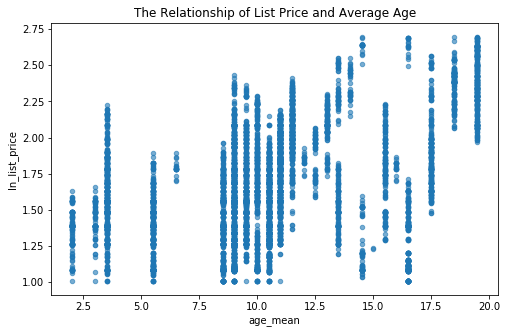

In [247]:
data.plot(kind = 'scatter',
          x = 'age_mean',
          y = 'ln_list_price',
          alpha = .6,
          title = 'The Relationship of List Price and Average Age',
          figsize = (8,5));

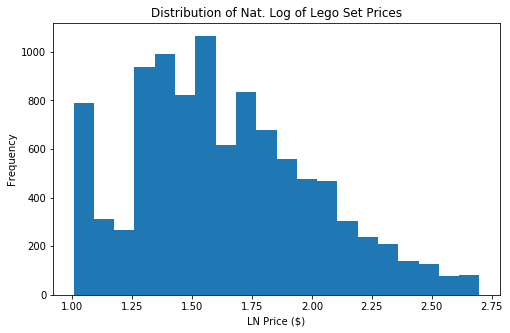

In [249]:
data['ln_list_price'].plot(kind = 'hist',
                        bins = 20,
                        title = 'Distribution of Nat. Log of Lego Set Prices',
                        figsize = (8,5))
plt.xlabel('LN Price ($)');

sklearn
train r^2 score: 0.8644730512912379
test r^2  score: 0.8640500721536634
train RMSE score: 0.13677230505264162
test RMSE  score: 0.13625504937672628

statsmodels
train r^2 score: 0.8644689596556885
test r^2  score: 0.8640185325692398
train RMSE score: 0.13677436965384118
test RMSE  score: 0.1362708536455679


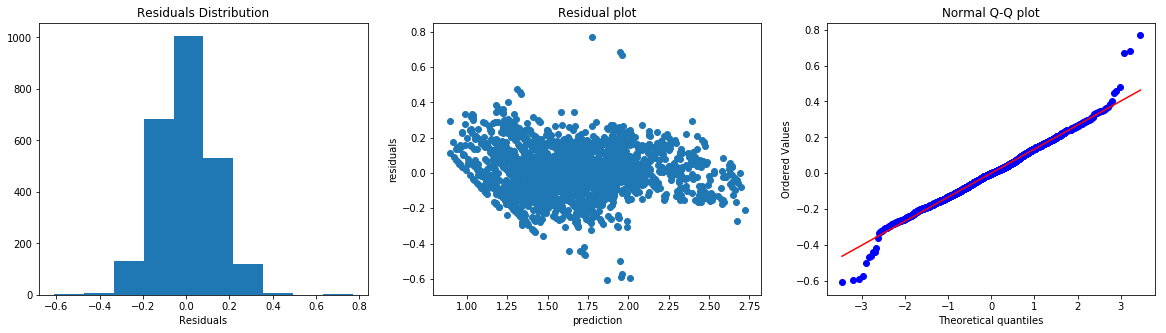

In [262]:
target = 'ln_list_price'
features = [
    
    'ln_piece_count',
    #'ln_piece_count^2',
    'ln_age_mean',
    'age_mean^2',
    #'age_mean^3',
    'num_reviews',
    'star_rating',
    'star_rating^2',
    #'val_star_rating',
    #'play_star_rating',
    'review_diff_int',
    'desc_word_count',
    'desc_bullet_count',
    'cont_tm',
    'cont_lego',
    'cont_battery',
    'AT', 
    'AU', 
    'BE', 
    'CA', 
    'CH', 
    'CZ', 
    'DE', 
    'DN',
    'ES', 
    'FI', 
    'FR', 
    'GB', 
    'IE', 
    'IT', 
    'LU', 
    'NL', 
    'NO', 
    'NZ', 
    'PL', 
    'PT',
    #'US',
    
    #'.', 
    'ADJ', 
    'ADP', 
    'ADV', 
    'CONJ', 
    #'DET', 
    'NOUN',
    #'NUM', 
    'PRON', 
    'PRT', 
    'VERB'
    
]

X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.25)

lin_model = LinearRegression().fit(X_train, y_train)

sm_model = sm.OLS(y_train, X_train).fit()

print('sklearn')
print('train r^2 score: ' + str(r2_score(y_train, lin_model.predict(X_train))))
print('test r^2  score: ' + str(r2_score(y_test,lin_model.predict(X_test))))
print('train RMSE score: ' + str(np.sqrt(mean_squared_error(y_train,lin_model.predict(X_train)))))
print('test RMSE  score: ' + str(np.sqrt(mean_squared_error(y_test,lin_model.predict(X_test)))))
print('')
print('statsmodels')
print('train r^2 score: ' + str(r2_score(y_train, sm_model.predict(X_train))))
print('test r^2  score: ' + str(r2_score(y_test,sm_model.predict(X_test))))
print('train RMSE score: ' + str(np.sqrt(mean_squared_error(y_train,sm_model.predict(X_train)))))
print('test RMSE  score: ' + str(np.sqrt(mean_squared_error(y_test,sm_model.predict(X_test)))))

diagnostic_plot(X_test, y_test)

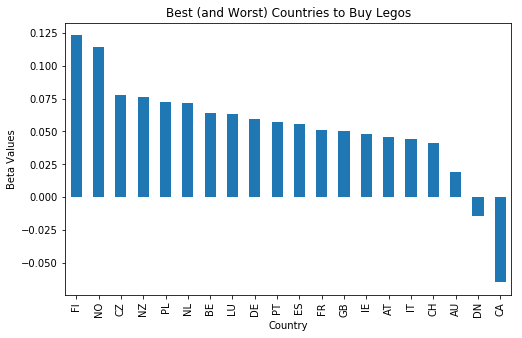

In [230]:
country_coeffs = pd.DataFrame({'feature':X_train.columns,'coeff':lin_model.coef_}).iloc[8:28,:]

pd.Series(data = country_coeffs['coeff'].values,
          index = country_coeffs['feature'].values).sort_values(ascending = False).plot(kind = 'bar',
                                                                                        color = '#1f77b4',
                                                                                       title = 'Best (and Worst) Countries to Buy Legos',
                                                                                       figsize = (8,5))
plt.ylabel('Beta Values')
plt.xlabel('Country');

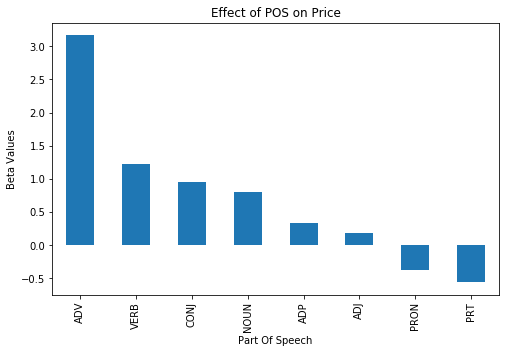

In [279]:
POS_coeffs = pd.DataFrame({'feature':X_train.columns,'coeff':lin_model.coef_}).iloc[32:40,:]

pd.Series(data = POS_coeffs['coeff'].values,
          index = POS_coeffs['feature'].values).sort_values(ascending = False).plot(kind = 'bar',
                                                                                        color = '#1f77b4',
                                                                                       title = 'Effect of POS on Price',
                                                                                       figsize = (8,5))
plt.ylabel('Beta Values')
plt.xlabel('Part Of Speech');

In [ ]:
data.sort_values('MD', ascending = False)['prod_long_desc'][221]

In [270]:
data['prod_long_desc'][8].split('\n')

['Celebrate the architectural diversity of London with this detailed LEGO® brick model. The LEGO Architecture Skyline Collection offers models suitable for display in the home and office, and has been developed for all with an interest in travel, architectural culture, history and design. Each set is scaled to give an accurate representation of the comparative size of each structure, with true-to-life color depiction. This set features the National Gallery, Nelson’s Column, London Eye, Big Ben (the Elizabeth Tower) and Tower Bridge, and is finished with a decorative “London” nameplate.',
 'Build a detailed model of the London skyline!',
 'Model features the National Gallery, Nelson’s Column, London Eye, Big Ben and Tower Bridge',
 'Includes collectible booklet containing information about the design, architecture and history of the building',
 'LEGO Archiecture models are compatible with all LEGO construction sets for creative building',
 'Measures over 5” high, 11” wide and 3” deep',


In [271]:
get_parts_of_speech(data['prod_long_desc'][8])

{'ADJ': 0.10559006211180125,
 'ADP': 0.11180124223602485,
 'CONJ': 0.062111801242236024,
 'DET': 0.12422360248447205,
 'NOUN': 0.4472049689440994,
 'NUM': 0.031055900621118012,
 'PRT': 0.012422360248447204,
 'VERB': 0.10559006211180125}